# Get corrections at a corner reflector (CR) location using GridGeococoding

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

import numpy as np
from scipy.interpolate import interp2d
from matplotlib import pyplot as plt

import s1etad
from s1etad import Sentinel1Etad, ECorrectionType
from s1etad.geometry import GridGeocoding

## Searching bursts in which the CR is present

Load the S1-ETAD product.

In [2]:
filename = '../../sample-products/S1B_IW_ETA__AXDH_20200127T113414_20200127T113858_020002_025D72_0096.SAFE'
eta = Sentinel1Etad(filename)

The CR position has been chosen to be in the overlap region of different bursts and swaths.

In [3]:
from shapely.geometry import Point

lat0 = +70.13  # 70° 7'48.65"N
lon0 = -76.19  # 76°11'41.55"W
h0 = 366

cr = Point(lon0, lat0)

Query for burst covering the CR.

In [4]:
selection = eta.query_burst(geometry=cr)
selection

bIndex  pIndex  sIndex  \
294     273      10       3   
193     275      10       2   
295     276      11       3   

                                             productID swathID  \
294  S1B_IW_SLC__1ADH_20200127T113802_20200127T1138...     IW3   
193  S1B_IW_SLC__1ADH_20200127T113802_20200127T1138...     IW2   
295  S1B_IW_SLC__1ADH_20200127T113827_20200127T1138...     IW3   

                   azimuthTimeMin                azimuthTimeMax  
294 2020-01-27 11:38:24.612132034 2020-01-27 11:38:27.806466524  
193 2020-01-27 11:38:26.396354902 2020-01-27 11:38:29.619467181  
295 2020-01-27 11:38:27.374799701 2020-01-27 11:38:30.569134191

## Get corrections at CR location

Retrieve the first burst.

In [5]:
burst = next(eta.iter_bursts(selection))

Get the grid of geodetic coordinates.

In [6]:
lats, lons, heights = burst.get_lat_lon_height()

Get the range and azimuth time axes.

In [7]:
azimuth_time, range_time = burst.get_burst_grid()

Initialize the Grid Geocoding object.

**NOTE**: if one uses time axis then consistent time coordinates shall be provided in all back-geocoding requests.

In [8]:
ebg = GridGeocoding(lats, lons, heights, xaxis=range_time, yaxis=azimuth_time)

Now it is possible to perform the back-geocoding i.e. computation of RADAR coordinates (tau, t) starting form geodetic coordinates (lat, lon, h):

   (lat, lon, h) -> (tau, t) 

In [9]:
tau, t = ebg.backward_geocode(lat0, lon0, h0)
tau, t

(array([0.00068153]), array([253.13628054]))

Of course it is also possible to make the inverse conversion:

In [10]:
lat1, lon1, h1 = ebg.forward_geocode(tau, t)
print(f'Initial coordinates:      (lat0, lon0, h0) = ({lat0}, {lon0}, {h0})')
print(f'Foeward geocoding output: (lat1, lon1, h1) = ({lat1.item()}, {lon1.item()}, {h1.item()})')

Initial coordinates:      (lat0, lon0, h0) = (70.13, -76.19, 366)
Foeward geocoding output: (lat1, lon1, h1) = (70.13000000000012, -76.19000000000213, 345.19365681816475)


### Using image coordinates (lines, samples)

It is also possible to initialize the GridGeocoding without providing time axes information.

In this case the geocoder will work using image coordinates (lines and samples) instead of range/azimuth times.

In [11]:
ebg = GridGeocoding(lats, lons, heights)

It is possible to perform back-geocoding, i.e. (lat, lon, h) -> (sample, line):

In [12]:
sample, line = ebg.backward_geocode(lat0, lon0, h0)
sample, line

(array([10.33385208]), array([104.2382231]))

and also to perform the forward conversion: (sample, line) -> (lat, lon, h)

In [13]:
lat1, lon1, h1 = ebg.forward_geocode(sample, line)
print(f'Initial coordinates:      (lat0, lon0, h0) = ({lat0}, {lon0}, {h0})')
print(f'Foeward geocoding output: (lat1, lon1, h1) = ({lat1.item()}, {lon1.item()}, {h1.item()})')

Initial coordinates:      (lat0, lon0, h0) = (70.13, -76.19, 366)
Foeward geocoding output: (lat1, lon1, h1) = (70.12999999999997, -76.18999999999998, 345.1936568136903)


## Putting all together

xy   IW3 273 [10.33385208] [104.2382231] [70.13] [-76.19] [345.19365681]
time IW3 273 [0.00068153] [253.13628054] [70.13] [-76.19] [345.19365682]
Interpoaltion by array coordinate [2.63362235] or time [2.63362235] should be the same
The total correction at lat/lon (70.13, -76.19) is  [2.63362235] m in range

xy   IW2 275 [464.33385204] [42.2382231] [70.13] [-76.19] [345.19366271]
time IW2 275 [0.00068153] [253.13628054] [70.13] [-76.19] [345.19366271]
Interpoaltion by array coordinate [3.15004682] or time [3.15004682] should be the same
The total correction at lat/lon (70.13, -76.19) is  [3.15004682] m in range

xy   IW3 276 [10.33385205] [8.2382231] [70.13] [-76.19] [345.19366085]
time IW3 276 [0.00068153] [253.13628054] [70.13] [-76.19] [345.19366086]
Interpoaltion by array coordinate [3.43524444] or time [3.43524444] should be the same
The total correction at lat/lon (70.13, -76.19) is  [3.43524444] m in range



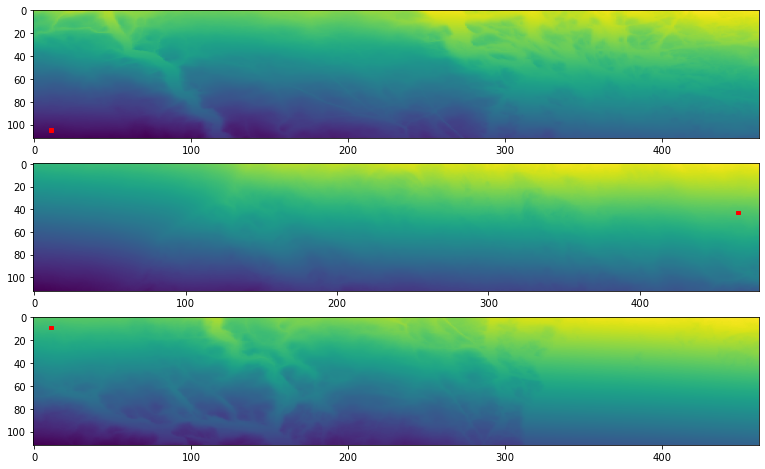

In [14]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(nrows=len(selection), ncols=1, figsize=[13, 8])

for loop, burst in enumerate(eta.iter_bursts(selection)):
    # coordinate grids
    lats, lons, heights = burst.get_lat_lon_height()

    # backward geocoding with image coordinates
    ebg = GridGeocoding(lats, lons, heights)
    x0, y0 = ebg.backward_geocode(lat0, lon0, h0) 
    print("xy  ", burst.swath_id, burst.burst_index, x0, y0,
          ebg.latitude(x0, y0), ebg.longitude(x0, y0), ebg.height(x0, y0))

    # get the range and azimuth times
    azimuth_time, range_time = burst.get_burst_grid()

    # backward geocoding with time coordinates
    ebg = GridGeocoding(lats, lons, heights,
                        xaxis=range_time, yaxis=azimuth_time)
    tau0, t0 = ebg.backward_geocode(lat0, lon0, h0) 
    print("time", burst.swath_id, burst.burst_index, tau0, t0,
          ebg.latitude(tau0, t0), ebg.longitude(tau0, t0), ebg.height(tau0, t0))
    
    # correction
    cor = burst.get_correction(s1etad.ECorrectionType.SUM, meter='True')

    ax[loop].imshow(cor['x'], aspect='auto')
    rec_half_size = 1
    p = Rectangle((x0 - rec_half_size, y0 - rec_half_size),
                  width=rec_half_size*2+1, height=rec_half_size*2+1,
                  color='red', fill=True)
    ax[loop].add_patch(p)

    # interpolate at the desired working (RADAR) coordinates
    f_t  = interp2d(range_time, azimuth_time, cor['x'])

    # get the image (lines and samples) axes
    yaxis = np.arange(azimuth_time.size)
    xaxis = np.arange(range_time.size)
    
    # interpolate at the desired working (image) coordinates
    f_ij = interp2d(xaxis, yaxis, cor['x'])
    
    print(f"Interpoaltion by array coordinate {f_ij(x0, y0)} or time {f_t(tau0,t0)} should be the same")
    print(f"The total correction at lat/lon {lat0, lon0} is  {f_ij(x0, y0)} m in range")
    print()

In [15]:
burst.radar_to_geodetic(tau0, t0) 

(array([70.13]), array([-76.19]), array([345.19366086]))

In [16]:
cor

{'x': array([[3.49604194, 3.49691115, 3.49730289, ..., 3.82785377, 3.8304929 ,
         3.83203849],
        [3.48959644, 3.48999044, 3.4893733 , ..., 3.81987377, 3.82197888,
         3.82407282],
        [3.48315835, 3.4835356 , 3.48297197, ..., 3.8173234 , 3.8183186 ,
         3.81717599],
        ...,
        [2.5892973 , 2.58881512, 2.58739174, ..., 2.98362816, 2.98421541,
         2.98479948],
        [2.57893314, 2.57848116, 2.57948612, ..., 2.97558522, 2.97617406,
         2.97675866],
        [2.56909729, 2.57009158, 2.57060984, ..., 2.96754318, 2.96813198,
         2.96871386]]),
 'y': array([[ 0.06291091,  0.06343373,  0.06280198, ..., -0.62483416,
         -0.61949097, -0.61650535],
        [ 0.05533918,  0.05469434,  0.05180551, ..., -0.64686918,
         -0.64284249, -0.63878479],
        [ 0.0476772 ,  0.04699454,  0.04410948, ..., -0.65730509,
         -0.65570317, -0.65868017],
        ...,
        [-0.73682517, -0.73933902, -0.73962994, ..., -2.5462182 ,
         -2.55